Some helpful resources:
- [Colab Tutorial with Database scheme](https://colab.research.google.com/github/cmap/lincs-workshop-2020/blob/main/notebooks/data_access/cmapBQ_Tutorial.ipynb)

In [1]:
import pandas as pd
import seaborn as sns
import anndata
from tqdm import tqdm
import requests
import scanpy as sc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [111]:
# URL with credentials
url = ('https://s3.amazonaws.com/data.clue.io/api/bq_creds/BQ-demo-credentials.json')

response = requests.get(url)
credentials_filepath='/Users/mamba/Desktop/BQ-demo-credentials.json'

with open(credentials_filepath, 'w') as f:
  f.write(response.text)

In [112]:
import cmapBQ.query as cmap_query
import cmapBQ.config as cmap_config

#credentials_filepath='/BQ-demo-credentials.json'
# Set up credentials
cmap_config.setup_credentials(credentials_filepath)
bq_client = cmap_config.get_bq_client()

In [113]:
from cmapPy.pandasGEXpress.parse import parse
#data1 = parse("/Users/mamba/Downloads/GSE92742_Broad_LINCS_Level2_GEX_delta_n49216x978.gctx")
data2 = parse("/Users/mamba/Downloads/GSE92742_Broad_LINCS_Level2_GEX_epsilon_n1269922x978.gctx")

adata = anndata.AnnData(X = data2.data_df.T)
adata.obs_names =  data2.data_df.columns.tolist()
adata.var_names = data2.data_df.index.tolist()
adata

AnnData object with n_obs × n_vars = 1269922 × 978

In [114]:
# var: gene names etc - saved in geneinfo table, rid = gene_id
rids = adata.var_names.astype(int).tolist()
var_df = cmap_query.cmap_genes(bq_client, gene_id=rids)

In [115]:
var_df.head(5)

,gene_id,gene_symbol,ensembl_id,gene_title,gene_type,src,feature_space
0,16,AARS,ENSG00000090861,alanyl-tRNA synthetase,protein-coding,NCBI,landmark
1,23,ABCF1,ENSG00000204574,ATP binding cassette subfamily F member 1,protein-coding,NCBI,landmark
2,25,ABL1,ENSG00000097007,"ABL proto-oncogene 1, non-receptor tyrosine ki...",protein-coding,NCBI,landmark
3,30,ACAA1,ENSG00000060971,acetyl-CoA acyltransferase 1,protein-coding,NCBI,landmark
4,39,ACAT2,ENSG00000120437,acetyl-CoA acetyltransferase 2,protein-coding,NCBI,landmark


In [ ]:
# cids are the unique identifiers for the samples (cells), we will now query more info about the samples
cids = adata.obs_names.tolist()
obs_df = pd.DataFrame()
step_size = 20000
for i in tqdm(range(0, len(cids), step_size)):
    obs_df = pd.concat((obs_df, cmap_query.cmap_profiles(bq_client, sample_id=cids[i:i+step_size])))

In [12]:
# save obs_df to csv
obs_df.to_csv('/Users/mamba/Desktop/obs_df_V2.csv')

In [116]:
obs_df = pd.read_csv('/Users/mamba/Desktop/obs_df_V2.csv')

/var/folders/zz/30xy72gx11z33hw95rnnfy1r0000gp/T/ipykernel_84197/1386159867.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_df = pd.read_csv('/Users/mamba/Desktop/obs_df_V2.csv')


In [117]:
obs_df

,Unnamed: 0,sample_id,det_plate,pert_id,cmap_name,pert_type,cell_iname,pert_itime,pert_idose,det_plate_1,build_name,project_code
0,0,AML001_HL60_6H_X2_B11:O13,AML001_HL60_6H_X2_B11,DMSO,DMSO,ctl_vehicle,HL60,6 h,NaN,AML001_HL60_6H_X2_B11,NaN,AML
1,1,AML001_HL60_6H_X2_B11:H22,AML001_HL60_6H_X2_B11,DMSO,DMSO,ctl_vehicle,HL60,6 h,NaN,AML001_HL60_6H_X2_B11,NaN,AML
2,2,AML001_HL60_6H_X2_B11:O11,AML001_HL60_6H_X2_B11,DMSO,DMSO,ctl_vehicle,HL60,6 h,NaN,AML001_HL60_6H_X2_B11,NaN,AML
3,3,AML001_PC3_6H_X1_F1B10:B17,AML001_PC3_6H_X1_F1B10,DMSO,DMSO,ctl_vehicle,PC3,6 h,NaN,AML001_PC3_6H_X1_F1B10,NaN,AML
4,4,AML001_PC3_6H_X1_F1B10:O23,AML001_PC3_6H_X1_F1B10,DMSO,DMSO,ctl_vehicle,PC3,6 h,NaN,AML001_PC3_6H_X1_F1B10,NaN,AML
...,...,...,...,...,...,...,...,...,...,...,...,...
1235687,9868,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:I13,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,TRCN0000072208,RFP,ctl_vector,U2OS,96 h,1 uL,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,NaN,TAK
1235688,9869,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:P19,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,TRCN0000208001,EMPTY_VECTOR,ctl_vector,U2OS,96 h,1 uL,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,NaN,TAK
1235689,9870,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:I24,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,TRCN0000072209,RFP,ctl_vector,U2OS,96 h,1 uL,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,NaN,TAK
1235690,9871,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:G14,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,TRCN0000196342,RPS6KB1,trt_sh,U2OS,96 h,1 uL,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,NaN,TAK


In [118]:
# now we can query compound info, where cmap_name=cmap_name
#compund_info = cmap_query.cmap_compounds(bq_client, cmap_name=obs_df['cmap_name'].tolist())
#print(list(set(obs_df['cmap_name'].tolist()) & set(compund_info['cmap_name'].tolist())))

cmap_names = obs_df['cmap_name'].unique().tolist()
compound_info = pd.DataFrame()
step_size = 20000
for i in tqdm(range(0, len(cmap_names), step_size)):
    compound_info = pd.concat((compound_info, cmap_query.cmap_compounds(bq_client, cmap_name=cmap_names[i:i+step_size])))

100%|██████████| 2/2 [00:07<00:00,  3.85s/it]


In [119]:
compound_info

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
0,BRD-A39230911,chlorphensin,None,None,NC(=O)OCC(O)COc1ccc(Cl)cc1,SKPLBLUECSEIFO-UHFFFAOYSA-N,chlorphenesin-carbamate
1,BRD-A77577770,BRD-A77577770,None,None,CCCCCCCCCCCCCCCC(=O)OC(CC(O)=O)C[N+](C)(C)C,XOMRRQXKHMYMOC-UHFFFAOYSA-O,palmitoylcarnitine
2,BRD-K13994703,BRD-K13994703,None,None,CC(C)NC[C@H](O)COc1cccc2ccccc12,AQHHHDLHHXJYJD-AWEZNQCLSA-N,propranolol-(S)
3,BRD-K17874705,BRD-K17874705,None,None,NCCc1ccccn1,XPQIPUZPSLAZDV-UHFFFAOYSA-N,2-pyridylethylamine
4,BRD-K27853494,BRD-K27853494,None,None,C[C@@H](N)[C@@H](O)c1ccccc1,DLNKOYKMWOXYQA-VXNVDRBHSA-N,phenylpropanolamine
...,...,...,...,...,...,...,...
1006,BRD-K40738845,BMS-777607,MERTK,Hepatocyte growth factor receptor inhibitor,CCOc1ccn(-c2ccc(F)cc2)c(=O)c1C(=O)Nc1ccc(Oc2cc...,VNBRGSXVFBYQNN-UHFFFAOYSA-N,None
1007,BRD-K40738845,BMS-777607,MET,Hepatocyte growth factor receptor inhibitor,CCOc1ccn(-c2ccc(F)cc2)c(=O)c1C(=O)Nc1ccc(Oc2cc...,VNBRGSXVFBYQNN-UHFFFAOYSA-N,None
1008,BRD-K40738845,BMS-777607,MST1R,Hepatocyte growth factor receptor inhibitor,CCOc1ccn(-c2ccc(F)cc2)c(=O)c1C(=O)Nc1ccc(Oc2cc...,VNBRGSXVFBYQNN-UHFFFAOYSA-N,None
1009,BRD-K40738845,BMS-777607,AXL,Hepatocyte growth factor receptor inhibitor,CCOc1ccn(-c2ccc(F)cc2)c(=O)c1C(=O)Nc1ccc(Oc2cc...,VNBRGSXVFBYQNN-UHFFFAOYSA-N,None


In [120]:
len(compound_info['cmap_name'].unique()) == len(compound_info['cmap_name'].tolist())

False

In [121]:
# We need to have only one row for each cmap_name in compund_info, let's inspect why we have some duplicates
# print example for entry in compund_info with same identical cmap_name
compound_info[compound_info['cmap_name'] == 'sunitinib']

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
342,BRD-K42828737,sunitinib,FLT1,KIT inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,sunitinib-malate
343,BRD-K42828737,sunitinib,FLT3,KIT inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,sunitinib-malate
344,BRD-K42828737,sunitinib,FLT4,KIT inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,sunitinib-malate
345,BRD-K42828737,sunitinib,KDR,KIT inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,sunitinib-malate
346,BRD-K42828737,sunitinib,KIT,KIT inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,sunitinib-malate
...,...,...,...,...,...,...,...
22093,BRD-M64432851,sunitinib,KDR,RET tyrosine kinase inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,None
22094,BRD-M64432851,sunitinib,KIT,RET tyrosine kinase inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,None
22095,BRD-M64432851,sunitinib,PDGFRA,RET tyrosine kinase inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,None
22096,BRD-M64432851,sunitinib,PDGFRB,RET tyrosine kinase inhibitor,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2/C(=O)Nc3ccc(F)...,WINHZLLDWRZWRT-ATVHPVEESA-N,None


In [122]:
# we can have different targets for the same cmap_name, however, we are only interested in the moa
# let's only keep the cmap_name and moa columns and drop duplicates
compound_info = compound_info[['cmap_name', 'moa']].drop_duplicates()
compound_info

#TODO: We still have duplicates, e.g. sunitinib can be KIT inhibitor or FLT3 inhibitor, discuss how to handle this

,cmap_name,moa
0,chlorphensin,None
1,BRD-A77577770,None
2,BRD-K13994703,None
3,BRD-K17874705,None
4,BRD-K27853494,None
...,...,...
1002,SR-144528,Cannabinoid receptor inverse agonist
1003,purpurogallin,Catechol O methyltransferase inhibitor
1004,BRD-K93367411,Kelch-like ECH-associated protein ligand
1005,BRD-K98948170,Kelch-like ECH-associated protein ligand


In [123]:
len(compound_info['cmap_name'].unique()) == len(compound_info['cmap_name'].tolist())

False

In [124]:
print(obs_df.shape)
obs_df = pd.merge(obs_df, compound_info, on='cmap_name', how='left')
print(obs_df.shape)

(1235692, 12)
(1302992, 13)


In [125]:
obs_df

,Unnamed: 0,sample_id,det_plate,pert_id,cmap_name,pert_type,cell_iname,pert_itime,pert_idose,det_plate_1,build_name,project_code,moa
0,0,AML001_HL60_6H_X2_B11:O13,AML001_HL60_6H_X2_B11,DMSO,DMSO,ctl_vehicle,HL60,6 h,NaN,AML001_HL60_6H_X2_B11,NaN,AML,None
1,1,AML001_HL60_6H_X2_B11:H22,AML001_HL60_6H_X2_B11,DMSO,DMSO,ctl_vehicle,HL60,6 h,NaN,AML001_HL60_6H_X2_B11,NaN,AML,None
2,2,AML001_HL60_6H_X2_B11:O11,AML001_HL60_6H_X2_B11,DMSO,DMSO,ctl_vehicle,HL60,6 h,NaN,AML001_HL60_6H_X2_B11,NaN,AML,None
3,3,AML001_PC3_6H_X1_F1B10:B17,AML001_PC3_6H_X1_F1B10,DMSO,DMSO,ctl_vehicle,PC3,6 h,NaN,AML001_PC3_6H_X1_F1B10,NaN,AML,None
4,4,AML001_PC3_6H_X1_F1B10:O23,AML001_PC3_6H_X1_F1B10,DMSO,DMSO,ctl_vehicle,PC3,6 h,NaN,AML001_PC3_6H_X1_F1B10,NaN,AML,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1302987,9868,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:I13,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,TRCN0000072208,RFP,ctl_vector,U2OS,96 h,1 uL,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,NaN,TAK,NaN
1302988,9869,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:P19,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,TRCN0000208001,EMPTY_VECTOR,ctl_vector,U2OS,96 h,1 uL,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,NaN,TAK,NaN
1302989,9870,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:I24,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,TRCN0000072209,RFP,ctl_vector,U2OS,96 h,1 uL,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,NaN,TAK,NaN
1302990,9871,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:G14,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,TRCN0000196342,RPS6KB1,trt_sh,U2OS,96 h,1 uL,TAK004_U2OS_96H_X2_B10_DUO52HI53LO,NaN,TAK,NaN


In [126]:
obs_df['moa'].value_counts()

moa
HDAC inhibitor                   9241
Dopamine receptor antagonist     6635
PI3K inhibitor                   6343
Cyclooxygenase inhibitor         5916
Serotonin receptor antagonist    5503
                                 ... 
Antifibrinolytic                    9
Succinimide antiepileptic           9
Fibrinogen stimulant                9
DOPA decarboxylase inhibitor        8
Anti-HCVE2                          8
Name: count, Length: 529, dtype: int64

In [127]:
# check if obs names are unique
print(len(adata.obs_names) == len(set(adata.obs_names)))
print(len(obs_df['sample_id']) == len(set(obs_df['sample_id'])))

True
False


In [128]:
# ToDo: Explore this more and find a better way to solve this
print(obs_df.shape)
obs_df.drop_duplicates(subset='sample_id', inplace=True)
print(obs_df.shape)

(1302992, 13)
(1235692, 13)


In [129]:
print(len(obs_df['sample_id']) == len(set(obs_df['sample_id'])))

True


In [130]:
# reorder var_df so that order in gene_id matches order in adata.var_names
var_df = var_df.set_index('gene_id').reindex(adata.var_names.astype(int)).reset_index()
adata.var = var_df

obs_df = obs_df.set_index('sample_id').reindex(adata.obs_names).reset_index()
adata.obs = obs_df

In [131]:
adata

AnnData object with n_obs × n_vars = 1269922 × 978
    obs: 'index', 'Unnamed: 0', 'det_plate', 'pert_id', 'cmap_name', 'pert_type', 'cell_iname', 'pert_itime', 'pert_idose', 'det_plate_1', 'build_name', 'project_code', 'moa'
    var: 'index', 'gene_symbol', 'ensembl_id', 'gene_title', 'gene_type', 'src', 'feature_space'

In [132]:
adata.obs['cmap_name'].value_counts()

cmap_name
DMSO             26843
UnTrt            15997
GFP               5810
LACZ              5683
LUCIFERASE        4653
                 ...  
DCAMKL2              1
TRIM26               1
BRD-K47471281        1
BRD-K60865324        1
RFX3                 1
Name: count, Length: 25529, dtype: int64

In [133]:
adata.obs['moa'].value_counts()

moa
HDAC inhibitor                     9241
Dopamine receptor antagonist       6586
PI3K inhibitor                     5464
HSP inhibitor                      5063
Estrogen receptor antagonist       4367
                                   ... 
Dopamine precursor                    9
Plasminogen activator inhibitor       8
DOPA decarboxylase inhibitor          8
Steroidal progestin                   8
Anti-HCVE2                            8
Name: count, Length: 452, dtype: int64

# Train regression classifier

In [134]:
# perform PCA
sc.pp.pca(adata, n_comps=50)

In [135]:
# log-normalize adata
#sc.pp.normalize_total(adata)
#sc.pp.log1p(adata)

In [136]:
top_100_perts = adata.obs['cmap_name'].value_counts().head(100).index.tolist()
print(adata.shape)
adata = adata[adata.obs['cmap_name'].isin(top_100_perts)]
print(adata.shape)

(1269922, 978)
(150153, 978)


In [137]:
# fit one logistic regression model for each perturbation, get the weights as embeddings
embeddings = {}
scores = []

for perturbation in tqdm(adata.obs['cmap_name'].unique()):
    #input_data = adata.X
    input_data = adata.obsm['X_pca']
    labels = np.where(adata.obs['cmap_name'] == perturbation, 1, 0)
    
    x_train, x_test, y_train, y_test = train_test_split(input_data, labels, test_size=0.1, random_state=42)
    
    model = LogisticRegression(class_weight='balanced', max_iter=10000)
    model.fit(x_train, y_train)
    
    score = model.score(x_test, y_test)
    scores.append(score)
    
    # get model weights for this perturbation
    weights = model.coef_
    embeddings[perturbation] = weights

100%|██████████| 100/100 [09:19<00:00,  5.60s/it]


<Axes: ylabel='Count'>

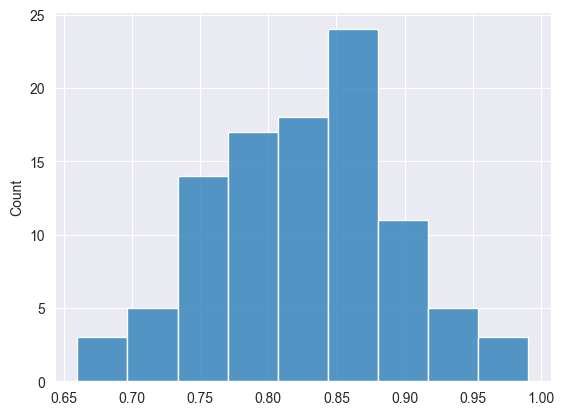

In [138]:
# plot scores
sns.histplot(scores)

In [139]:
# create Anndata with weights as X, and perturbation name and observation as obs variables
embeddings_adata = anndata.AnnData(X = np.array(list(embeddings.values())).squeeze())
embeddings_adata.obs_names = list(embeddings.keys())

# create dataframe with perturbation name and moa
pert_and_moa = adata.obs[['cmap_name', 'moa']].drop_duplicates()

# map perturbation name to moa
embeddings_adata.obs['moa'] = embeddings_adata.obs_names.map(pert_and_moa.set_index('cmap_name')['moa'])

In [140]:
embeddings_adata

AnnData object with n_obs × n_vars = 100 × 50
    obs: 'moa'

In [141]:
embeddings_adata.obs['moa'].value_counts()

moa
HDAC inhibitor                              5
Estrogen receptor antagonist                3
Kelch-like ECH-associated protein ligand    2
HSP inhibitor                               2
PI3K inhibitor                              1
Estrogen receptor agonist                   1
Tyrosine kinase inhibitor                   1
Insulin sensitizer                          1
PLK inhibitor                               1
Retinoid receptor ligand                    1
Dopamine receptor antagonist                1
IKK inhibitor                               1
SIRT activator                              1
Glucocorticoid receptor agonist             1
Anti-cancer agent                           1
JAK inhibitor                               1
Lipoxygenase inhibitor                      1
Aurora kinase inhibitor                     1
MTOR inhibitor                              1
Name: count, dtype: int64

/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/homebrew/Caskroom/mambaforge/base/envs/pertpy1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


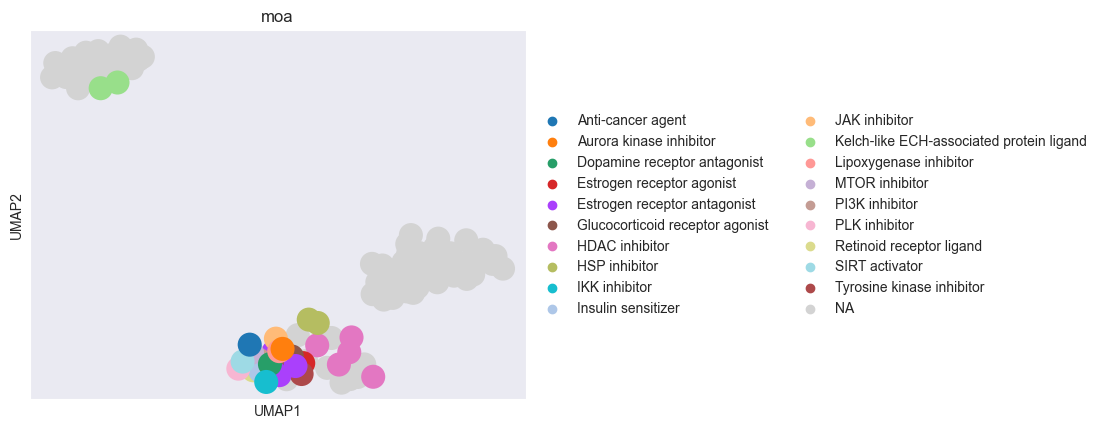

In [142]:
sc.pp.neighbors(embeddings_adata, use_rep='X')
sc.tl.umap(embeddings_adata)
sc.pl.umap(embeddings_adata, color=['moa'])